In [35]:

# Import required libraries
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# Dataset path and selection parameters
dataset = "/home/lucian/University/MSc-Courses/BiometricSystems/data/"
selected_person = "007"
selected_hand = "r"
selected_spectrum = "940"

# Load matching image files
pattern = f"{selected_person}_{selected_hand}_{selected_spectrum}_*.jpg"
matching_files = glob.glob(dataset + pattern)
selected_files = glob.glob(dataset + pattern)[:1]  # Load first 6 images for demonstration


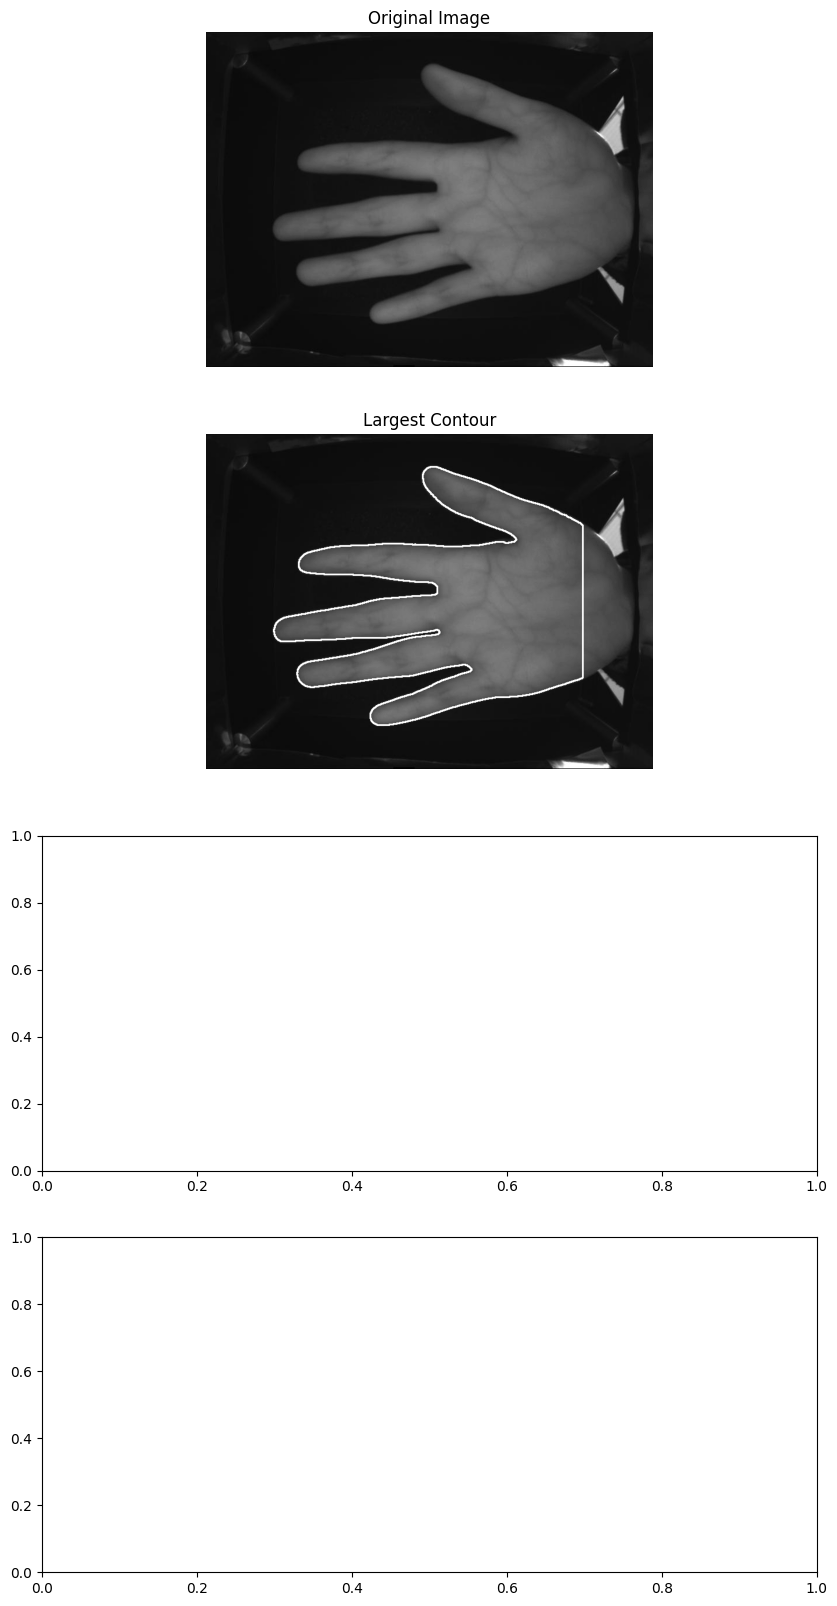

In [36]:
image = cv2.imread(selected_files[0], cv2.IMREAD_GRAYSCALE)

cropped_image = image[:, :image.shape[1] - 120]
blurred = cv2.GaussianBlur(cropped_image, (5, 5), 0)
_, thresholded = cv2.threshold(blurred, 50, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key=cv2.contourArea)

# Set up a single-column plot
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 20))

# Original image
axes[0].imshow(image, cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off')

# Draw the largest contour
image_with_contour = np.copy(image)
cv2.drawContours(image_with_contour, [largest_contour], -1, (255, 255, 255), 2)
axes[1].imshow(image_with_contour, cmap='gray')
axes[1].set_title("Largest Contour")
axes[1].axis('off')

# Compute convex hull and defects
hull = cv2.convexHull(largest_contour, returnPoints=False)
defects = cv2.convexityDefects(largest_contour, hull)

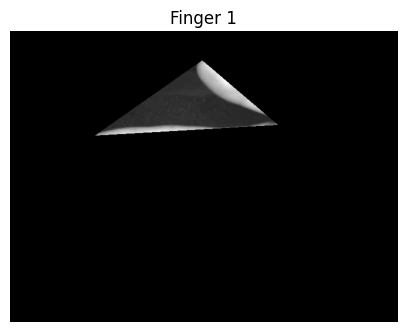

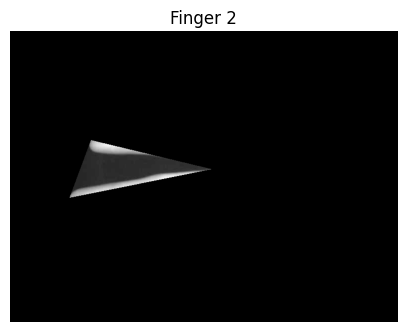

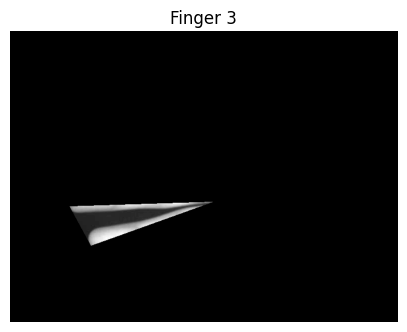

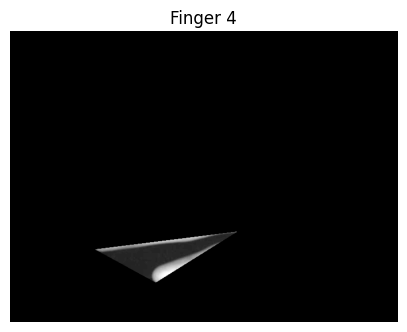

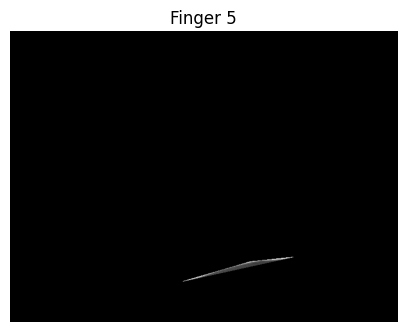

In [37]:
# Assuming `largest_contour` and `defects` are already calculated
fingers = []  # List to store isolated fingers

if defects is not None:
    for i in range(defects.shape[0]):
        s, e, f, d = defects[i, 0]
        start = tuple(largest_contour[s][0])
        end = tuple(largest_contour[e][0])
        far = tuple(largest_contour[f][0])

        # Calculate the area of the triangle formed by start, end, and far
        triangle_contour = np.array([start, end, far])
        area = 0.5 * abs(
            triangle_contour[0][0] * (triangle_contour[1][1] - triangle_contour[2][1]) +
            triangle_contour[1][0] * (triangle_contour[2][1] - triangle_contour[0][1]) +
            triangle_contour[2][0] * (triangle_contour[0][1] - triangle_contour[1][1])
        )

        # Filter by area to separate fingers
        if area > 500:  # Adjust the threshold based on image size
            mask = np.zeros_like(image, dtype=np.uint8)
            cv2.fillPoly(mask, [triangle_contour.astype(np.int32)], 255)

            # Apply the mask to isolate this region
            finger = cv2.bitwise_and(image, image, mask=mask)
            fingers.append(finger)

# Display each isolated finger
for idx, finger in enumerate(fingers):
    plt.figure(figsize=(5, 5))
    plt.imshow(finger, cmap='gray')
    plt.title(f"Finger {idx + 1}")
    plt.axis('off')
    plt.show()